#### Imports

In [1]:
import os
import re
import sys
import numpy as np
import matplotlib.pyplot as plt

import networkx as nx

In [2]:
sys.path.append('..')

In [3]:
from src.utils.image_utils import load_czi_images, enhance_cell_image_contrast
from src.utils.plot_utils import show_3d_segmentation_overlay
from src.track import *



Welcome to CellposeSAM, cellpose v
cellpose version: 	4.0.5.dev16+g79b0fcb 
platform:       	linux 
python version: 	3.12.9 
torch version:  	2.7.1+cu126! The neural network component of
CPSAM is much larger than in previous versions and CPU excution is slow. 
We encourage users to use GPU/MPS if available. 




#### Functions

#### Inputs

In [4]:
czi_file_path = '/home/dafei/data/MS2/gRNA2_12.03.25-st-13-II---.czi'
seg_maps_dir = '/home/dafei/output/MS2/3d_cell_segmentation/gRNA2_12.03.25-st-13-II---/masks'

In [5]:
image_data = load_czi_images(czi_file_path)

Successfully loaded /home/dafei/data/MS2/gRNA2_12.03.25-st-13-II---.czi
data shape: (1, 80, 2, 9, 1024, 1024, 1)


In [6]:
def extract_time_number(filename):
    """Extract time number from filename like z_stack_t5_seg_masks.npz"""
    try:
        # Find the pattern t{number}_
        match = re.search(r't(\d+)_', filename)
        return int(match.group(1)) if match else 0
    except:
        return 0

# Sort files by time number
files = sorted([os.path.join(seg_maps_dir, x) for x in os.listdir(seg_maps_dir) 
                if x.startswith('z_stack_t') and x.endswith('_seg_masks.npz')], 
               key=extract_time_number)

In [7]:
files


['/home/dafei/output/MS2/3d_cell_segmentation/gRNA2_12.03.25-st-13-II---/masks/z_stack_t0_seg_masks.npz',
 '/home/dafei/output/MS2/3d_cell_segmentation/gRNA2_12.03.25-st-13-II---/masks/z_stack_t1_seg_masks.npz',
 '/home/dafei/output/MS2/3d_cell_segmentation/gRNA2_12.03.25-st-13-II---/masks/z_stack_t2_seg_masks.npz',
 '/home/dafei/output/MS2/3d_cell_segmentation/gRNA2_12.03.25-st-13-II---/masks/z_stack_t3_seg_masks.npz',
 '/home/dafei/output/MS2/3d_cell_segmentation/gRNA2_12.03.25-st-13-II---/masks/z_stack_t4_seg_masks.npz',
 '/home/dafei/output/MS2/3d_cell_segmentation/gRNA2_12.03.25-st-13-II---/masks/z_stack_t5_seg_masks.npz',
 '/home/dafei/output/MS2/3d_cell_segmentation/gRNA2_12.03.25-st-13-II---/masks/z_stack_t6_seg_masks.npz',
 '/home/dafei/output/MS2/3d_cell_segmentation/gRNA2_12.03.25-st-13-II---/masks/z_stack_t7_seg_masks.npz',
 '/home/dafei/output/MS2/3d_cell_segmentation/gRNA2_12.03.25-st-13-II---/masks/z_stack_t8_seg_masks.npz',
 '/home/dafei/output/MS2/3d_cell_segmentation/

In [8]:
z_stack_seg_mask_t0 = np.load(files[0])['masks']
z_stack_t0 = image_data[0, 0, 1, :, :, :, 0]

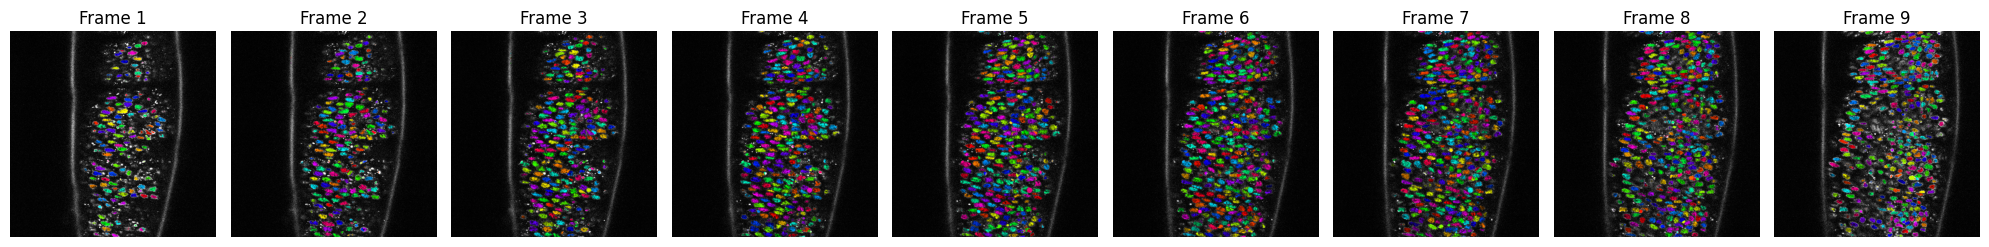

In [9]:
show_3d_segmentation_overlay(z_stack_t0, z_stack_seg_mask_t0)

In [10]:
z_stack_seg_mask_t1 = np.load(files[1])['masks']
z_stack_t1 = image_data[0, 1, 1, :, :, :, 0]

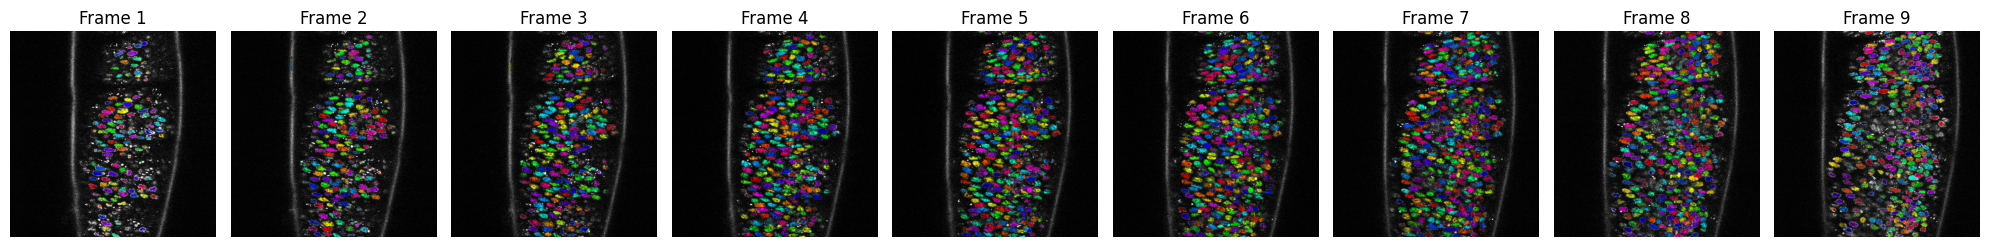

In [11]:
show_3d_segmentation_overlay(z_stack_t1, z_stack_seg_mask_t1)

In [12]:
z_stack_seg_mask_t2 = np.load(files[2])['masks']
z_stack_t2 = image_data[0, 2, 1, :, :, :, 0]

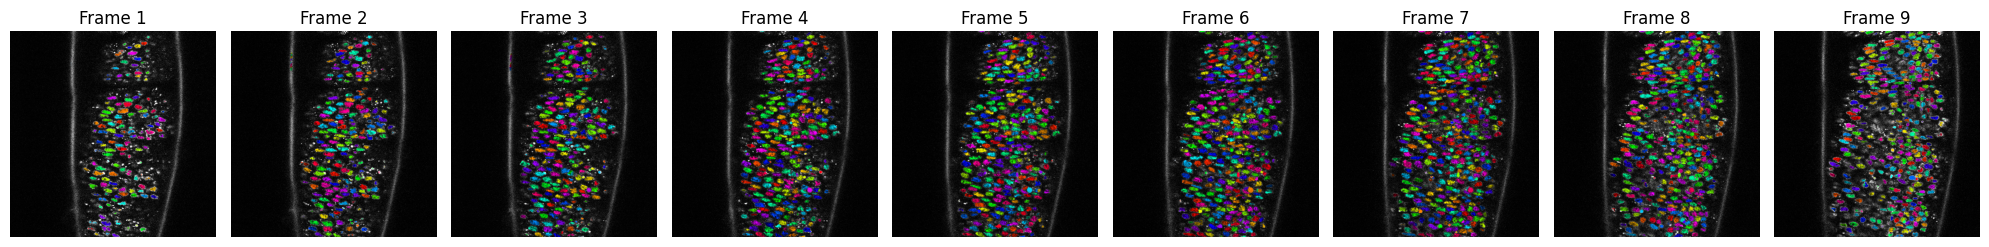

In [13]:
show_3d_segmentation_overlay(z_stack_t2, z_stack_seg_mask_t2)

Tracking cells using adjacency graph

In [14]:
# Compute cell locations for the first frame
centers1 = get_cell_centers(z_stack_seg_mask_t0)
labels1 = np.unique(z_stack_seg_mask_t0)
g1 = compute_cell_location(centers=centers1, labels=labels1)

# Compute cell locations for the second frame
centers2 = get_cell_centers(z_stack_seg_mask_t1)
labels2 = np.unique(z_stack_seg_mask_t1)
g2 = compute_cell_location(centers=centers2, labels=labels2)

# Compute cell locations for the third frame
centers3 = get_cell_centers(z_stack_seg_mask_t2)
labels3 = np.unique(z_stack_seg_mask_t2)
g3 = compute_cell_location(centers=centers3, labels=labels3)

In [15]:
matches_1_t0_0 = match_points_between_frames(g1, g2, z_stack_seg_mask_t0, z_stack_seg_mask_t1,distance_threshold=np.sqrt(3))
matches_2_t1_1 = match_points_between_frames(g2, g3, z_stack_seg_mask_t1, z_stack_seg_mask_t2,distance_threshold=np.sqrt(3))

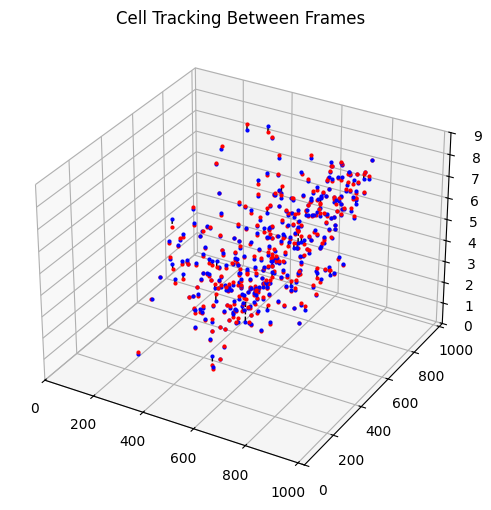

In [ ]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

for label_t_plus1 in range(1,449):
    label_t = matches_1_t0_0[label_t_plus1] if label_t_plus1 in matches_1_t0_0 else None
    if label_t is None:
        continue  # Skip if no match found
    # Get positions for the current label in both frames
    row_mask_t1 =centers2[:, 0] == label_t_plus1
    matching_rows1 = centers2[row_mask_t1]
    pos1 = matching_rows1[0][1:]

    row_mask_t2 = centers1[:, 0] == label_t
    matching_rows2 = centers1[row_mask_t2]
    pos2 = matching_rows2[0][1:]
    
    ax.scatter(*pos1, color='blue', label=f'Cell {label_t_plus1} in Frame 2',s=4)
    ax.scatter(*pos2, color='red', label=f'Cell {label_t} in Frame 1' if pos2 is not None else 'No match', s=4)
    ax.plot([pos1[0], pos2[0]], [pos1[1], pos2[1]], [pos1[2], pos2[2]], 'black', linewidth=1, linestyle='--' if pos2 is not None else 'None')
    ax.set_title('Cell Tracking Between Frames')
    ax.set_xlim([0, z_stack_seg_mask_t1.shape[1]])
    ax.set_ylim([0, z_stack_seg_mask_t1.shape[2]])
    ax.set_zlim([0, z_stack_seg_mask_t1.shape[0]])
#ax.legend()
ax.grid(True)
plt.show()

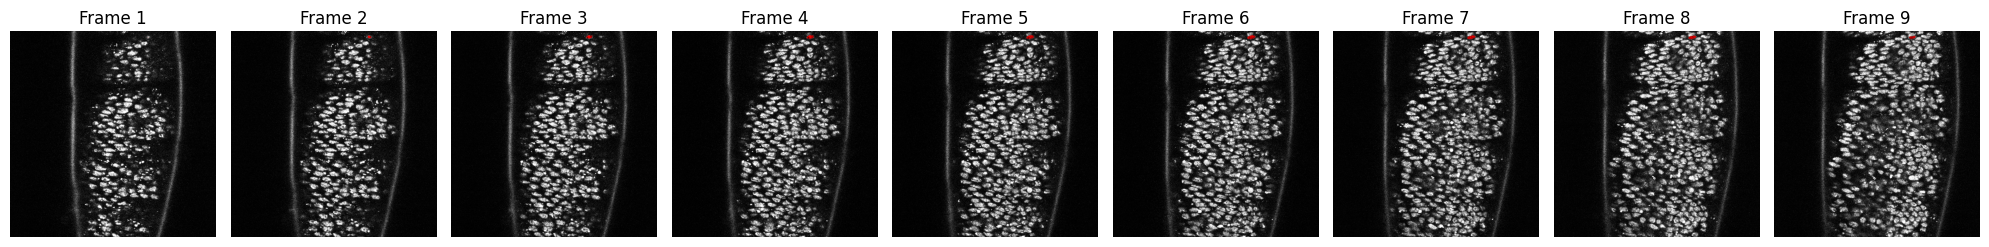

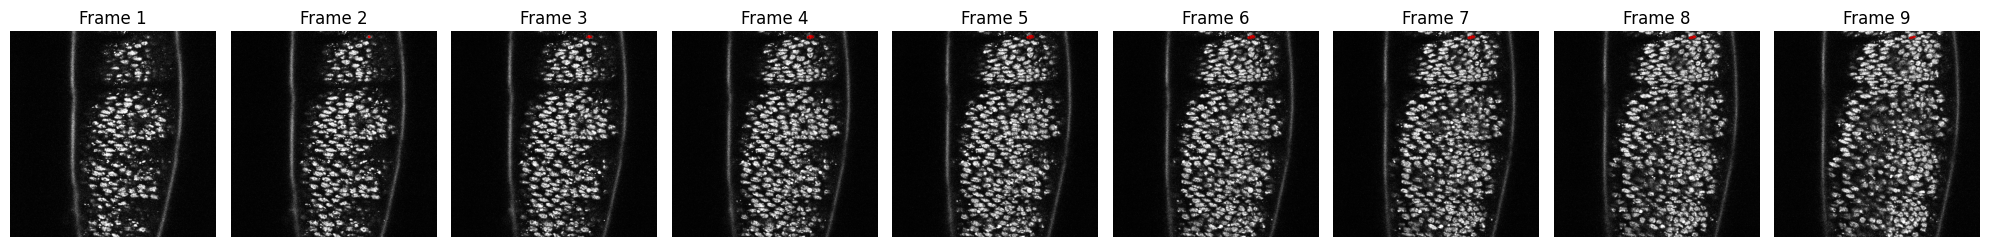

In [21]:
label_t_plus1 = 1
label_t = matches_1_t0_0[label_t_plus1] if label_t_plus1 in matches_1_t0_0 else None

cell_mask_t_plus1 = (z_stack_seg_mask_t1 == label_t_plus1).astype(np.uint8)
cell_mask_t = (z_stack_seg_mask_t0 == label_t).astype(np.uint8)

show_3d_segmentation_overlay(z_stack_t1, cell_mask_t_plus1)
show_3d_segmentation_overlay(z_stack_t0, cell_mask_t)